In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import datetime as dt

from sklearn.svm import SVC
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split, RandomizedSearchCV, cross_val_score
from sklearn.metrics import accuracy_score, classification_report, ConfusionMatrixDisplay
from imblearn.under_sampling import NearMiss
from sklearn.feature_selection import RFE

In [3]:
df = pd.read_csv("D:\\Descargas\\archive\\Hotel Reservations.csv") #es mejor descomprimir un archivo y luego al google drive
df.head()

,Booking_ID,no_of_adults,no_of_children,no_of_weekend_nights,no_of_week_nights,type_of_meal_plan,required_car_parking_space,room_type_reserved,lead_time,arrival_year,arrival_month,arrival_date,market_segment_type,repeated_guest,no_of_previous_cancellations,no_of_previous_bookings_not_canceled,avg_price_per_room,no_of_special_requests,booking_status
0,INN00001,2,0,1,2,Meal Plan 1,0,Room_Type 1,224,2017,10,2,Offline,0,0,0,65.00,0,Not_Canceled
1,INN00002,2,0,2,3,Not Selected,0,Room_Type 1,5,2018,11,6,Online,0,0,0,106.68,1,Not_Canceled
2,INN00003,1,0,2,1,Meal Plan 1,0,Room_Type 1,1,2018,2,28,Online,0,0,0,60.00,0,Canceled
3,INN00004,2,0,0,2,Meal Plan 1,0,Room_Type 1,211,2018,5,20,Online,0,0,0,100.00,0,Canceled
4,INN00005,2,0,1,1,Not Selected,0,Room_Type 1,48,2018,4,11,Online,0,0,0,94.50,0,Canceled


In [4]:
df.shape

(36275, 19)

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 36275 entries, 0 to 36274
Data columns (total 19 columns):
 #   Column                                Non-Null Count  Dtype  
---  ------                                --------------  -----  
 0   Booking_ID                            36275 non-null  object 
 1   no_of_adults                          36275 non-null  int64  
 2   no_of_children                        36275 non-null  int64  
 3   no_of_weekend_nights                  36275 non-null  int64  
 4   no_of_week_nights                     36275 non-null  int64  
 5   type_of_meal_plan                     36275 non-null  object 
 6   required_car_parking_space            36275 non-null  int64  
 7   room_type_reserved                    36275 non-null  object 
 8   lead_time                             36275 non-null  int64  
 9   arrival_year                          36275 non-null  int64  
 10  arrival_month                         36275 non-null  int64  
 11  arrival_date   

In [6]:
df.isnull().sum()

Booking_ID                              0
no_of_adults                            0
no_of_children                          0
no_of_weekend_nights                    0
no_of_week_nights                       0
type_of_meal_plan                       0
required_car_parking_space              0
room_type_reserved                      0
lead_time                               0
arrival_year                            0
arrival_month                           0
arrival_date                            0
market_segment_type                     0
repeated_guest                          0
no_of_previous_cancellations            0
no_of_previous_bookings_not_canceled    0
avg_price_per_room                      0
no_of_special_requests                  0
booking_status                          0
dtype: int64

In [7]:
df.duplicated().sum()

0

In [8]:
df = df.drop(["Booking_ID", "arrival_year"], axis=1)

In [9]:
df.booking_status = df.booking_status.replace("Not_Canceled", 1).replace("Canceled", 0)

In [10]:
df.shape

(36275, 17)

##### TRANSFORMACIÓN DE VARIABLES DUMMY

In [11]:
df_c_dummy = df.columns[df.dtypes == object]
df_dummy = pd.get_dummies(data=df, prefix=df_c_dummy, drop_first=True)
df_dummy.head()

,no_of_adults,no_of_children,no_of_weekend_nights,no_of_week_nights,required_car_parking_space,lead_time,arrival_month,arrival_date,repeated_guest,no_of_previous_cancellations,...,room_type_reserved_Room_Type 2,room_type_reserved_Room_Type 3,room_type_reserved_Room_Type 4,room_type_reserved_Room_Type 5,room_type_reserved_Room_Type 6,room_type_reserved_Room_Type 7,market_segment_type_Complementary,market_segment_type_Corporate,market_segment_type_Offline,market_segment_type_Online
0,2,0,1,2,0,224,10,2,0,0,...,0,0,0,0,0,0,0,0,1,0
1,2,0,2,3,0,5,11,6,0,0,...,0,0,0,0,0,0,0,0,0,1
2,1,0,2,1,0,1,2,28,0,0,...,0,0,0,0,0,0,0,0,0,1
3,2,0,0,2,0,211,5,20,0,0,...,0,0,0,0,0,0,0,0,0,1
4,2,0,1,1,0,48,4,11,0,0,...,0,0,0,0,0,0,0,0,0,1


In [12]:
X = df_dummy.drop("booking_status", axis=1)
y = df_dummy["booking_status"].values.reshape(-1,1)

scaler_X = MinMaxScaler()
scaler_y = MinMaxScaler()

X = pd.DataFrame(scaler_X.fit_transform(X), columns=X.columns)
y = scaler_y.fit_transform(y)

In [13]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

##### BALANCEO DE LAS CLASES

Si una clase es dominante en cantidad respecto al otro, puede ocacionar cesgo, para evitar eso balanceamos los datos.

In [14]:
df_dummy.booking_status.value_counts()

1    24390
0    11885
Name: booking_status, dtype: int64

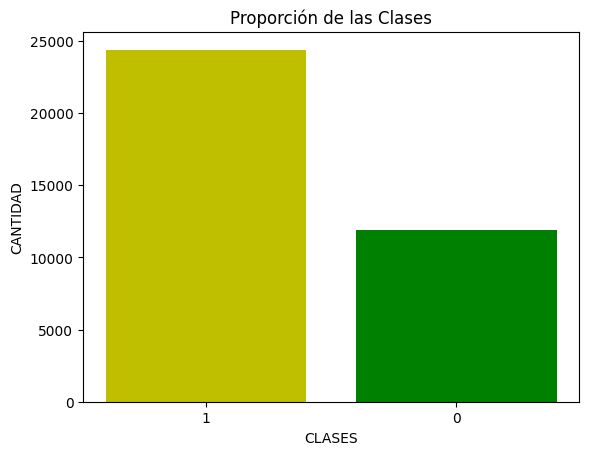

In [15]:
plt.bar(x=df.booking_status.astype(str).unique(), height = df.booking_status.value_counts(), color = ["y", "g"]);
plt.title("Proporción de las Clases")
plt.xlabel("CLASES")
plt.ylabel("CANTIDAD")
plt.show()

In [16]:
from imblearn.under_sampling import NearMiss
nm = NearMiss()
X_train_sm, y_train_sm = nm.fit_resample(X_train, y_train)

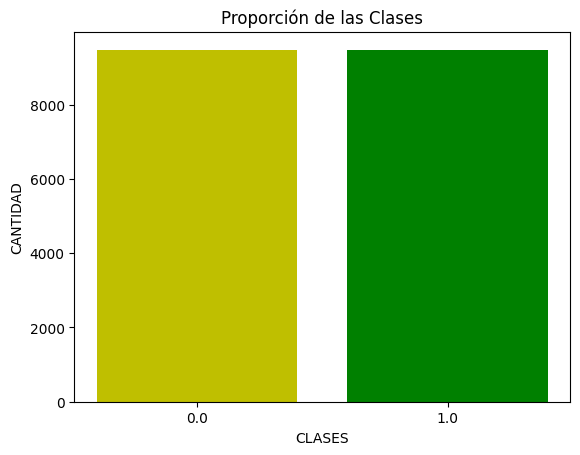

In [17]:
y_df = pd.DataFrame(y_train_sm)

plt.bar(x=y_df[0].astype(str).unique(), height = y_df.value_counts(), color = ["y", "g"]);
plt.title("Proporción de las Clases")
plt.xlabel("CLASES")
plt.ylabel("CANTIDAD")
plt.show()

##### SVC

In [26]:
model = SVC()

param_dist = {'kernel' : ['rbf'],
            'C' : [1,10,100,500],
            'gamma' : [0.1,0.5,0.01]}
    

random_search = RandomizedSearchCV(
    model, param_distributions=
                    param_dist, 
                    n_iter=10,
                    cv=10,
                    n_jobs=-1
)

random_search.fit(X_train_sm, y_train_sm);

In [ ]:
best_parameters = random_search.best_params_
print("best_parameters: ", best_parameters)
best_accuracy = random_search.best_score_
print("best_accuracy: ", best_accuracy)

best_parameters:  {'kernel': 'rbf', 'gamma': 0.5, 'C': 500}
best_accuracy:  0.776206602029854


##### PREDICCÍON

In [18]:
rbf = SVC(kernel="rbf", C=500, gamma=0.5).fit(X_train_sm, y_train_sm)
y_train_pred = rbf.predict(X_train_sm)
y_test_pred = rbf.predict(X_test)

In [19]:
print("Accuracy: {:.2f} %".format(accuracy_score(y_test, y_test_pred)*100))

Accuracy: 72.09 %


In [ ]:
accuracies = cross_val_score(estimator = svc, X = X_train_sm, y = y_train_sm, cv = 10, n_jobs=-1)
print("Validación Cruzada: {:.2f} %".format(accuracies.mean()*100))

Validación Cruzada: 75.10 %


In [ ]:
print("Metrics:\n {}".format(classification_report(y_test, y_test_pred)))

Metrics:
               precision    recall  f1-score   support

         0.0       0.56      0.78      0.65      2401
         1.0       0.86      0.69      0.77      4854

    accuracy                           0.72      7255
   macro avg       0.71      0.74      0.71      7255
weighted avg       0.76      0.72      0.73      7255



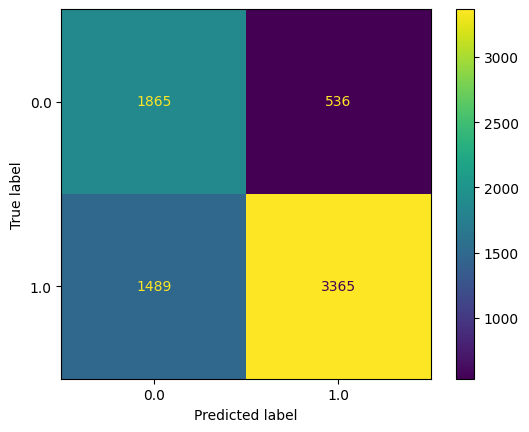

In [20]:
ConfusionMatrixDisplay.from_predictions(y_test, y_test_pred);